In [1]:
# Articles
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data = pd.read_csv("../data/state-daily-stats.csv")
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [4]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [5]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])

In [6]:
daily_new_cases

,date,daily_new_cases
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,1
...,...,...
407,2021-03-03,66714
408,2021-03-04,67415
409,2021-03-05,65682
410,2021-03-06,56606


### Update dates to proper datetime for modeling

In [7]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
daily_new_cases

,date,daily_new_cases
40,03-01-2020,18
41,03-02-2020,16
42,03-03-2020,21
43,03-04-2020,36
44,03-05-2020,67
...,...,...
407,03-03-2021,66714
408,03-04-2021,67415
409,03-05-2021,65682
410,03-06-2021,56606


In [9]:
daily_new_cases.set_index("date", inplace=True)

### Check Autocorrelation (ACF, PACF)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

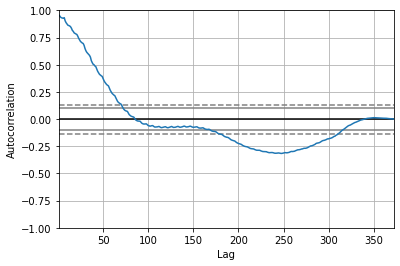

In [11]:
autocorrelation_plot(daily_new_cases)

**Data Transformation**
- By the above, we see some seasonal spikes
- We also see that the time series is not stationary

In [211]:
# Taking the log for this data provides better results than .diff() 
# decompose = statsmodels.tsa.seasonal.seasonal_decompose(daily_new_cases, model="multiplicative", freq=7)
test_df = np.log(daily_new_cases)
# log_diff_test = test_df["daily_new_cases"]
# test_df = daily_new_cases
# test_df.fillna(0, inplace=True)
# decompose.plot(seasonal=False)
# statsmodels.tsa.seasonal.DecomposeResult(observed, seasonal, trend, resid)
# decompose(observed, seasonal, trend, resid)

In [212]:
# decompose

In [213]:
# Replot ACF / PACF to check data
# ACF = plot_acf(decompose)
# PACF = plot_pacf(decompose)

**The PACF above looks good, less so for the ACF.**
- Let's check the Dickey-Fuller Score and P-Value
- A P-Value > .05 means our data still isn't stationary

In [214]:
result = adfuller(test_df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.308273767139734
p-value: 0.014512663468547885


- The P-Value is ok, and the data appears to be stationary for the most part. 
- We'll move forward with splitting our data into training/testing

**Training / Testing**
- This pretty much splits the data into 75/25

In [215]:
training = test_df[:250]
testing = test_df[250:]

## ARIMA Model

- We can start with an arima model to see what our scores are

In [216]:
import warnings
warnings.filterwarnings("ignore") 

model = ARIMA(training, order=(1,0,3))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:        daily_new_cases   No. Observations:                  250
Model:                     ARMA(1, 3)   Log Likelihood                  83.891
Method:                       css-mle   S.D. of innovations              0.171
Date:                Mon, 08 Mar 2021   AIC                           -155.781
Time:                        19:39:53   BIC                           -134.652
Sample:                    03-01-2020   HQIC                          -147.277
                         - 11-05-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.8672      3.643      2.160      0.031       0.728      15.007
ar.L1.daily_new_cases     0.9982      0.002    408.009      0.000       0.993       1.003
ma.L1.da

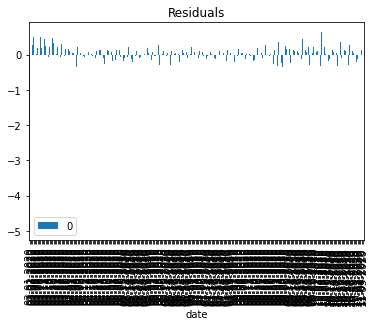

In [217]:
# Show the Residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind="bar", title="Residuals")
plt.show()

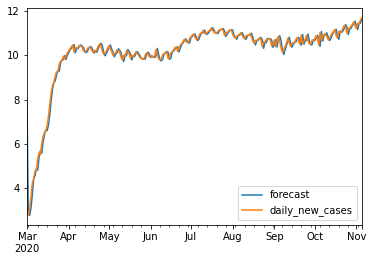

In [218]:
model_fit.plot_predict()
plt.show()

In [219]:
model_1_pred = model_fit.forecast(steps=10) 

In [220]:
model_1_pred

(array([11.7278317 , 11.74685901, 11.7479179 , 11.74077217, 11.73363959,
        11.72652015, 11.71941382, 11.71232057, 11.70524039, 11.69817324]),
 array([0.17079702, 0.26144959, 0.34254309, 0.41882059, 0.48298234,
        0.53937027, 0.59021737, 0.63685278, 0.68014399, 0.72069442]),
 array([[11.3930757 , 12.06258769],
        [11.23442722, 12.2592908 ],
        [11.07654579, 12.41929002],
        [10.91989889, 12.56164545],
        [10.78701161, 12.68026758],
        [10.66937384, 12.78366647],
        [10.56260903, 12.87621861],
        [10.46411205, 12.96052909],
        [10.37218266, 13.03829811],
        [10.28563813, 13.11070835]]))

## ARIMA / SARMIA Testing

- Grid Searching for best model orders
- Some code (mainly grid searches) is modeled / adopted from: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [221]:
import pmdarima as pm

In [222]:
amodel = pm.auto_arima(training, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(amodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-154.750, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1875.167, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1541.481, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-155.157, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1229.393, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-153.649, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-156.175, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=996.562, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-152.997, Time=0.49 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-155.781, Time=0.54 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 2.604 seconds
                               SARIMAX Results                                
Dep. Variable:      

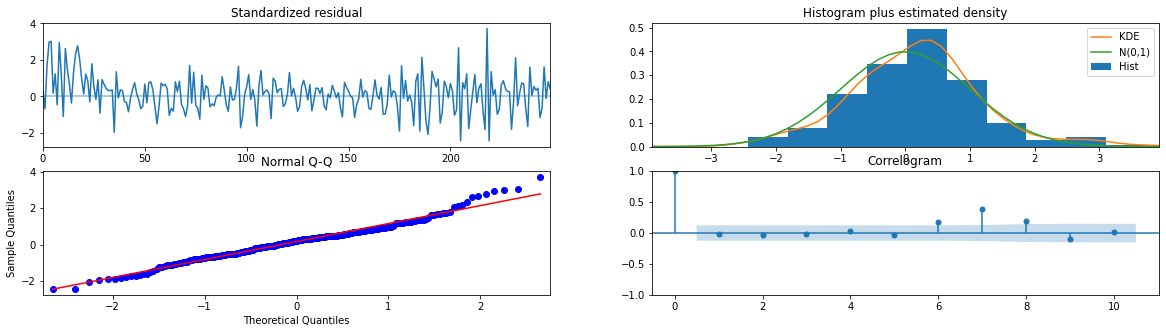

In [223]:
amodel.plot_diagnostics(figsize=(20,5))
plt.show()

In [224]:
n_periods = 119
arima_predictions = amodel.predict(n_periods=n_periods)

In [225]:
arima = []
for x in arima_predictions:
    p = np.expm1(x)
    arima.append(round(p))
    
arima

[124182,
 126806,
 127243,
 126673,
 126106,
 125542,
 124980,
 124421,
 123865,
 123312,
 122761,
 122213,
 121667,
 121124,
 120584,
 120047,
 119512,
 118979,
 118449,
 117922,
 117398,
 116875,
 116356,
 115839,
 115324,
 114812,
 114302,
 113795,
 113290,
 112788,
 112288,
 111790,
 111295,
 110802,
 110312,
 109824,
 109338,
 108855,
 108374,
 107895,
 107419,
 106944,
 106472,
 106003,
 105535,
 105070,
 104607,
 104147,
 103688,
 103232,
 102778,
 102326,
 101876,
 101428,
 100983,
 100540,
 100098,
 99659,
 99222,
 98787,
 98354,
 97923,
 97495,
 97068,
 96643,
 96220,
 95800,
 95381,
 94964,
 94550,
 94137,
 93726,
 93317,
 92910,
 92505,
 92102,
 91701,
 91302,
 90904,
 90509,
 90115,
 89723,
 89334,
 88945,
 88559,
 88175,
 87792,
 87411,
 87032,
 86655,
 86280,
 85906,
 85534,
 85164,
 84796,
 84429,
 84064,
 83701,
 83339,
 82980,
 82621,
 82265,
 81910,
 81557,
 81206,
 80856,
 80508,
 80161,
 79816,
 79473,
 79131,
 78791,
 78453,
 78116,
 77780,
 77446,
 77114,
 76784,

In [226]:
arima_df = pd.DataFrame(arima)
arima_df.rename(columns={0: "arima_model"}, inplace=True)

In [227]:
testing

,daily_new_cases
date,
11-06-2020,11.796773
11-07-2020,11.743497
11-08-2020,11.546515
11-09-2020,11.778676
11-10-2020,11.847610
...,...
03-03-2021,11.108170
03-04-2021,11.118623
03-05-2021,11.092580


In [228]:
arima_analysis = testing.reset_index()

for index, row in arima_analysis.iterrows():
    x = row[1]
    arima_analysis.at[index, "original_daily"] = np.expm1(x)

In [229]:
arima_analysis = pd.merge(arima_analysis, arima_df, left_index=True, right_index=True)
arima_analysis.set_index("date", inplace=True)
arima_analysis.drop(columns="daily_new_cases", inplace=True)

<AxesSubplot:xlabel='date'>

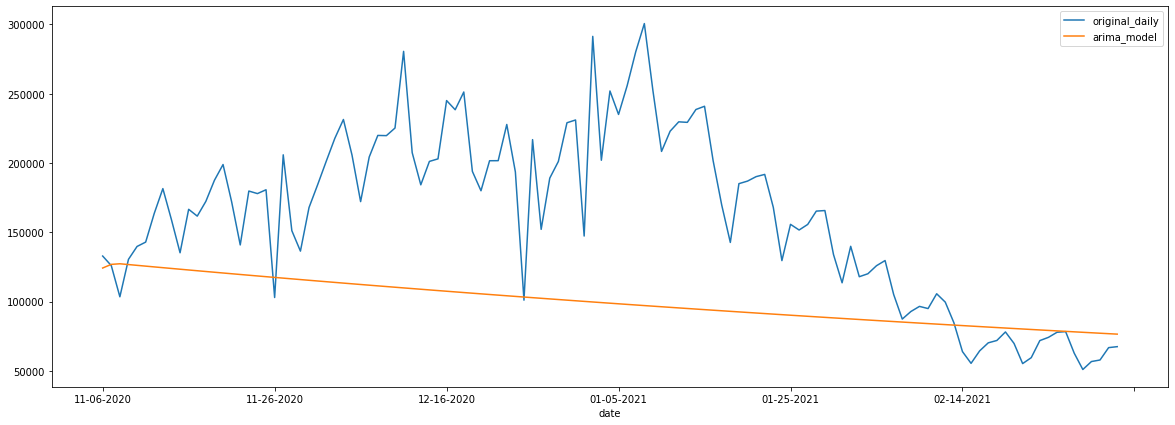

In [230]:
# Doesn't capture seasonality, only the trend
arima_analysis.plot(figsize=(20, 7))

## SARIMA Model: Grid Search

In [231]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(training, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-268.088, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-165.405, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-270.686, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-268.542, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-191.161, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-275.204, Time=0.62 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=-275.198, Time=0.90 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=-276.443, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-269.762, Time=0.15 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=-274.972, Time=1.43 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-275.029, Time=0.41 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-274.282, Time=0.21 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=-279.799, Time=0.35 sec
 ARIMA(2,1,0)(0,1,1)[7]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  250
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood                 169.008
Date:                           Mon, 08 Mar 2021   AIC                           -324.017
Time:                                   19:41:35   BIC                           -299.594
Sample:                                        0   HQIC                          -314.179
                                           - 250                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9834      0.018     54.949      0.000       0.948       1.018
ma.L1         -1.2321      0.044    -28.089      0.000      -1.318      -1.146
ma.L2          0.3782      0.043      8.727      0.000       0.293       0.463
ar.S.L7       -0.7919      0.169     -4.681      0.000      -1.124      -0.460
ma.S.L7       -0.1876      0.210     -0.893      0.372      -0.599       0.224
ma.S.L14      -0.5326      0.183     -2.908      0.004      -0.891      -0.174
sigma2         0.0140      0.001     15.727      0.000       0.012       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                89.38
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.01
Prob(H) (two-sided):                  0.38   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [232]:
n_periods = 120
predictions_seasonal = smodel.predict(n_periods=n_periods)

<AxesSubplot:>

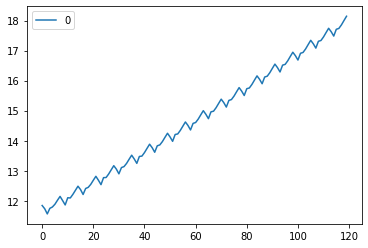

In [233]:
pd.DataFrame(predictions_seasonal).plot()

In [234]:
predictions_list = []

for x in predictions_seasonal:
    prediction = np.expm1(x)
    predictions_list.append(round(prediction))

In [235]:
sarima_model = pd.DataFrame(predictions_list)
sarima_model.rename(columns={0:"sarima_model"}, inplace=True)

In [236]:
sarima_model

,sarima_model
0,138867
1,124609
2,104994
3,126359
4,132237
...,...
115,49059404
116,50464318
117,56761915
118,65668053


In [237]:
arima_analysis.reset_index(inplace=True)

In [238]:
model_analyses = pd.merge(arima_analysis, sarima_model, left_index=True, right_index=True)
# model_analyses.drop(columns={"index"}, inplace=True)

<AxesSubplot:>

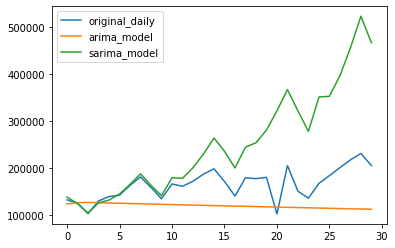

In [239]:
model_analyses[:30].plot()

# Finalized SARIMA Model Below

**Test on Training Data once more to make sure**

In [183]:
# First, test 
training 

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
11-01-2020,11.214452
11-02-2020,11.451188
11-03-2020,11.434055


In [184]:
# Fit model
mod = sm.tsa.statespace.SARIMAX(training, trend='c', order=(1,1,2), seasonal_order=(1, 1, 2, 7))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                   daily_new_cases   No. Observations:                  250
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood                 167.946
Date:                           Mon, 08 Mar 2021   AIC                           -319.893
Time:                                   19:17:17   BIC                           -291.981
Sample:                               03-01-2020   HQIC                          -308.649
                                    - 11-05-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.001     -0.875      0.381      -0.002       0.001
ar.L1          0.9532      0.034     28.100

In [65]:
# # SARIMAX(1, 1, 2)x(1, 1, 2, 7)
# mod = sm.tsa.statespace.SARIMAX(testing, trend='c', order=(1,1,1), seasonal_order=(1, 1, 2, 7))
# res = mod.fit(disp=False)
# print(res.summary())

In [120]:
SARIMA_predictions = res.forecast(steps=10)
SARIMA_new = pd.DataFrame(SARIMA_predictions)

In [121]:
SARIMA_new
for index, row in SARIMA_new.iterrows():
    sarima_p = round(np.expm1(row["predicted_mean"]))
    SARIMA_new.at[index, "sarima_model_new"] = sarima_p

<AxesSubplot:>

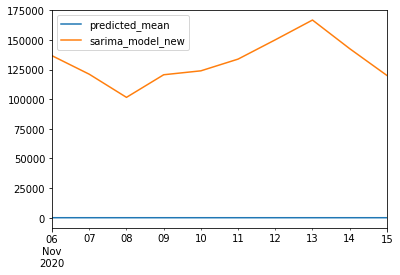

In [123]:
SARIMA_new.plot()

In [69]:
observed = daily_new_cases[-122:]

In [70]:
observed

,daily_new_cases
date,
11-06-2020,132823
11-07-2020,125932
11-08-2020,103416
11-09-2020,130441
11-10-2020,139750
...,...
03-03-2021,66714
03-04-2021,67415
03-05-2021,65682


In [71]:
SARIMA_new.drop(columns={"predicted_mean"}, inplace=True)

In [72]:
SARIMA_new

,sarima_model_new
2020-11-06,132637.0
2020-11-07,113038.0
2020-11-08,92340.0
2020-11-09,110110.0
2020-11-10,110578.0
2020-11-11,119502.0
2020-11-12,131461.0
2020-11-13,142108.0
2020-11-14,117395.0
2020-11-15,97346.0


<AxesSubplot:>

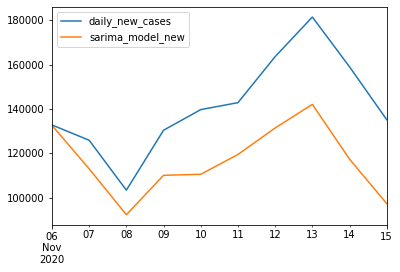

In [73]:
pd.merge(observed, SARIMA_new, left_index=True, right_index=True ).plot()

In [74]:
ten_day_observed = observed[:10]
ten_day_observed

,daily_new_cases
date,
11-06-2020,132823
11-07-2020,125932
11-08-2020,103416
11-09-2020,130441
11-10-2020,139750
11-11-2020,142885
11-12-2020,163640
11-13-2020,181497
11-14-2020,159033


In [75]:
first_ten_sarima = SARIMA_new[:10]
first_ten_sarima

,sarima_model_new
2020-11-06,132637.0
2020-11-07,113038.0
2020-11-08,92340.0
2020-11-09,110110.0
2020-11-10,110578.0
2020-11-11,119502.0
2020-11-12,131461.0
2020-11-13,142108.0
2020-11-14,117395.0
2020-11-15,97346.0


<AxesSubplot:>

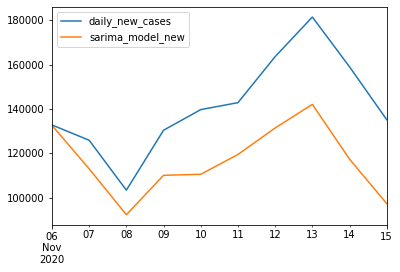

In [76]:
pd.merge(ten_day_observed, first_ten_sarima, left_index=True, right_index=True).plot()

In [77]:
log_daily_new_cases = np.log(daily_new_cases)

In [78]:
log_daily_new_cases

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
03-03-2021,11.108170
03-04-2021,11.118623
03-05-2021,11.092580


In [79]:
# # SARIMAX(1, 1, 2)x(1, 1, 2, 7)
final_mod = sm.tsa.statespace.SARIMAX(log_daily_new_cases, trend='c', order=(1,1,1), seasonal_order=(1, 1, 2, 7))
final_res = final_mod.fit(disp=False)
print(res.summary())

                                       SARIMAX Results                                        
Dep. Variable:                        daily_new_cases   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                 145.051
Date:                                Mon, 08 Mar 2021   AIC                           -276.102
Time:                                        15:09:22   BIC                           -251.680
Sample:                                    03-01-2020   HQIC                          -266.264
                                         - 11-05-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0168      0.011     -1.577      0.115      -0.038       0.004
ar.

In [80]:
final_res.forecast(steps=10)

2021-03-08    10.705861
2021-03-09    10.728702
2021-03-10    10.804016
2021-03-11    10.814237
2021-03-12    10.789336
2021-03-13    10.633535
2021-03-14    10.349572
2021-03-15    10.420182
2021-03-16    10.448373
2021-03-17    10.503870
Freq: D, Name: predicted_mean, dtype: float64

In [82]:
next_ten_days_prediction_df = pd.DataFrame(round(np.expm1(final_res.forecast(steps=10))))
next_ten_days_prediction_df

,predicted_mean
2021-03-08,44616.0
2021-03-09,45646.0
2021-03-10,49217.0
2021-03-11,49723.0
2021-03-12,48500.0
2021-03-13,41503.0
2021-03-14,31243.0
2021-03-15,33529.0
2021-03-16,34487.0
2021-03-17,36455.0


In [83]:
today = dt.date.today().strftime("%Y-%m-%d")
today

'2021-03-08'

In [84]:
next_ten_days_prediction_df.to_csv(f"../data/{today}_ten_day_prediction.csv", index_label="date")

In [97]:
next_ten_days_prediction_df.reset_index(inplace=True)
next_ten_days_prediction_df.rename(columns={"index": "date"}, inplace=True)


# Upload 10-Day Predictions to AWS RDS

In [98]:
# Config Variables, and SQLalchemy
from config import endpoint, username, password
from sqlalchemy import create_engine

engine = create_engine(f'postgresql://uscovid:{password}@{endpoint}/us_covid_db')
connection = engine.connect()

In [99]:
next_ten_days_prediction_df.to_sql('ten_day_prediction', index=False, if_exists='replace', con=connection)
engine.execute('ALTER TABLE ten_day_prediction ADD PRIMARY KEY (date);')